In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import datasets
from torch.utils.data import DataLoader
import torch.optim as optim
import torchvision
import numpy as np
from torchvision import transforms


In [2]:
class n_net(nn.Module):
    def __init__(self):
        super(n_net,self).__init__()
        self.n1 = nn.Linear(784,100)
        self.relu = nn.ReLU()
        self.n2 = nn.Linear(100,100)
        self.n3 = nn.Linear(100,10)
    def forward(self,x):
        x1 = self.n1(x)
        x2 = self.relu(x1)
        x3 = self.n2(x2)
        x4 = self.relu(x3)
        x5 = self.n3(x4)
        return x5

In [ ]:
USE_CUDA = torch.cuda.is_available()
device = torch.device("cuda" if USE_CUDA else "cpu")

In [3]:
DOWNLOAD_ROOT = 'MNIST_data/'

dataset_1 = datasets.MNIST(root=DOWNLOAD_ROOT,train=True,transform=transforms.ToTensor(),download=True)
dataset_2 = datasets.MNIST(root=DOWNLOAD_ROOT,train=False,transform=transforms.ToTensor(),download=True)


In [4]:
BATCH_SIZE = 128
dataset_1_loader = DataLoader(dataset_1, batch_size=BATCH_SIZE, shuffle=True,drop_last=True)
dataset_2_loader = DataLoader(dataset_2, batch_size=BATCH_SIZE, shuffle=True,drop_last=True)

In [5]:
LEARNING_RATE = 0.01
torch.manual_seed(7777)
if device == 'cuda':
    torch.cuda.manual_seed_all(777)

model = n_net()
model.zero_grad()
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(),lr=LEARNING_RATE)

In [6]:
TOTAL_BATCH = len(dataset_1_loader)
EPOCHS = np.arange(0,100)
loss_list = []
accuracy_list = []
for epoch in EPOCHS:
    cost = 0
    for image, label in dataset_1_loader:
        image = image.reshape(BATCH_SIZE,784)
        optimizer.zero_grad()
        predicted = model.forward(image)
        loss = loss_function(predicted,label)
        loss.backward()
        optimizer.step()
        cost+=loss
    with torch.no_grad():
        total = 0
        correct = 0
        for image, label in dataset_2_loader:
            image = image.reshape(BATCH_SIZE,784)
            out = model(image)
            _,predict = torch.max(out.data, 1)
            total += label.size(0)
            correct += (predict==label).sum()
    average_cost = cost/TOTAL_BATCH
    accuracy = 100*correct/total
    loss_list.append(average_cost.detach().numpy())
    accuracy_list.append(accuracy)
    print("epoch : {} | loss : {:.6f}" .format(epoch, average_cost))
    print("Accuracy : {:.2f}".format(accuracy))
    print("---------------------")



epoch : 0 | loss : 2.178835
Accuracy : 57.07
---------------------
epoch : 1 | loss : 1.333699
Accuracy : 80.81
---------------------
epoch : 2 | loss : 0.680126
Accuracy : 85.70
---------------------
epoch : 3 | loss : 0.496338
Accuracy : 88.24
---------------------
epoch : 4 | loss : 0.420924
Accuracy : 89.54
---------------------
epoch : 5 | loss : 0.380197
Accuracy : 90.07
---------------------
epoch : 6 | loss : 0.353888
Accuracy : 90.79
---------------------
epoch : 7 | loss : 0.334613
Accuracy : 91.02
---------------------
epoch : 8 | loss : 0.319357
Accuracy : 91.41
---------------------
epoch : 9 | loss : 0.306695
Accuracy : 91.79
---------------------
epoch : 10 | loss : 0.295452
Accuracy : 91.92
---------------------
epoch : 11 | loss : 0.285000
Accuracy : 92.24
---------------------
epoch : 12 | loss : 0.275961
Accuracy : 92.57
---------------------
epoch : 13 | loss : 0.267229
Accuracy : 92.91
---------------------
epoch : 14 | loss : 0.258871
Accuracy : 92.90
------------

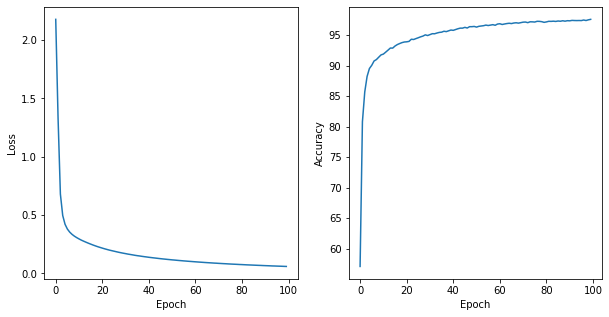

In [7]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(EPOCHS,loss_list)
plt.subplot(1,2,2)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(EPOCHS, accuracy_list)
plt.show()